In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rdlib.rdlib41 as rd

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var


px,py =var('px:4'),var('py:4')

from sympy import var

NSilF = './RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト


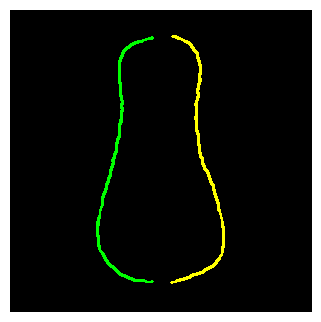

In [2]:
# 画像の左右の輪郭線を抽出
img = imgs[0]
conLeft,conRight = rd.getCntPairWithImg(img)
canvas = cv2.cvtColor(np.zeros_like(img) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0),thickness=2)
rd.drawContours(canvas,conRight,color=(0,255,255),thickness=2)
plt.figure(dpi=100)
rd.plotimg(canvas)

In [3]:
n_samples = 20 # 標本点の数

# 輪郭点を（チェインの並び順に）等間隔に n_samples 個サンプリングする。
cntL = (np.array(conLeft))[list(map(int,np.linspace(0, len(conLeft)-1,n_samples)))]
cntR = (np.array(conRight))[list(map(int,np.linspace(0, len(conRight)-1,n_samples)))]

print('cntL='+','.join([str(v) for v in cntL]),'\ncntR='+','.join([str(v) for v in cntR]))

cntL=[144  27],[129  33],[115  43],[111  58],[112  74],[113  89],[113 104],[111 119],[108 135],[105 150],[102 165],[ 98 180],[ 94 196],[ 89 211],[ 88 226],[ 90 241],[ 99 256],[113 268],[128 274],[144 275] 
cntR=[165  26],[179  32],[190  46],[193  61],[191  76],[190  91],[189 106],[189 121],[191 136],[195 151],[201 166],[206 181],[211 196],[215 211],[217 226],[216 241],[209 256],[194 266],[179 272],[164 277]


In [5]:
rd.BezierCurve.setParameters()

precPara:        0.1
errorThres:      0.5
paraResolution:  0.001
debugmode:       False



In [6]:
bezL =  rd.BezierCurve(cntL,N=5)
bezR =  rd.BezierCurve(cntR,N=5)
rd.BezierCurve.toggledebugmode() # デバッグモードの切り替え
# BezierCurve.setParameters(precPara=1.0,errorThres=1.0)
res,cpx,cpy,LbezresX,LbezresY,tpara = bezL.fit()
res,cpx,cpy,RbezresX,RbezresY,tpara = bezR.fit()
# BezierCurve.setParameters()



debugmode: True
.error:1.0613887265214368, drift:0.18686237688392288
.error:0.9136941694020253, drift:0.10975999300332523
.error:0.8385947506184349, drift:0.07744002295429715
.error:0.7941210335052337, drift:0.0650243799281159
.error:0.7610652953526813, drift:0.052953702395707805
.error:0.738768192621112, drift:0.04486536964563713

.error:0.8856384581367175, drift:0.211149600558909
.error:0.7316898562909335, drift:0.11410246380420934
.error:0.6402792341227781, drift:0.08793231115830906
.error:0.5806015382138113, drift:0.07010952686467814
.error:0.5554794247752941, drift:0.06145173889792373
.error:0.5311687092284162, drift:0.04496634811509002



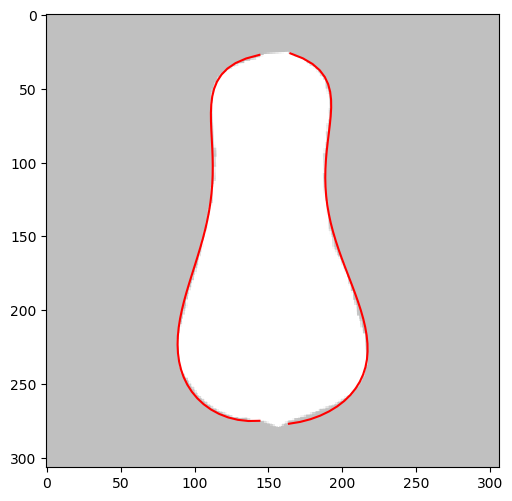

In [9]:
rd.drawBez2(img,bezL=(LbezresX,LbezresY),bezR=(RbezresX,RbezresY),saveImage=True,savepath="./test")